In [1]:
import pandas as pd
from pathlib import Path
import json
import matplotlib.pyplot as plt
from openrarity import TokenCollection
from collections import defaultdict
import numpy as np
import math
from tqdm import tqdm

DATA = Path("../data/regression-tests/v2")


# Rank Collections


In [5]:
collections = list((DATA / "metadata").glob("*.json"))
collections = [DATA / f"metadata/{c}.json" for c in ['beanzofficial',
 'clonex',
 'collectvoxtownstar',
 'cryptopunks',
 'decentraland-wearables',
 'kaiju-kingz',
 'karafuru',
 'murakami-flowers-2022-official',
 'official-v1-punks',
 'parallelalpha',
 'punks-comic',
 'sneaky-vampire-syndicate',
 'somnium-space',
 'veefriends',
 'wolf-game']]
for c in (pbar := tqdm(collections)):
    pbar.set_description(c.stem)

    tokens = json.loads(c.read_text())
    tc = TokenCollection("non-fungible", tokens)
    ranks = tc.rank_collection()
    (DATA / f"1.0.0a1/{c.stem}.json").write_text(json.dumps(ranks, indent=2))
    del tokens, tc, ranks


clonex:   6%|▋         | 6/93 [00:05<01:14,  1.17it/s]                  


KeyboardInterrupt: 

# Compare Versions


Match: 52	MisMatch: 15


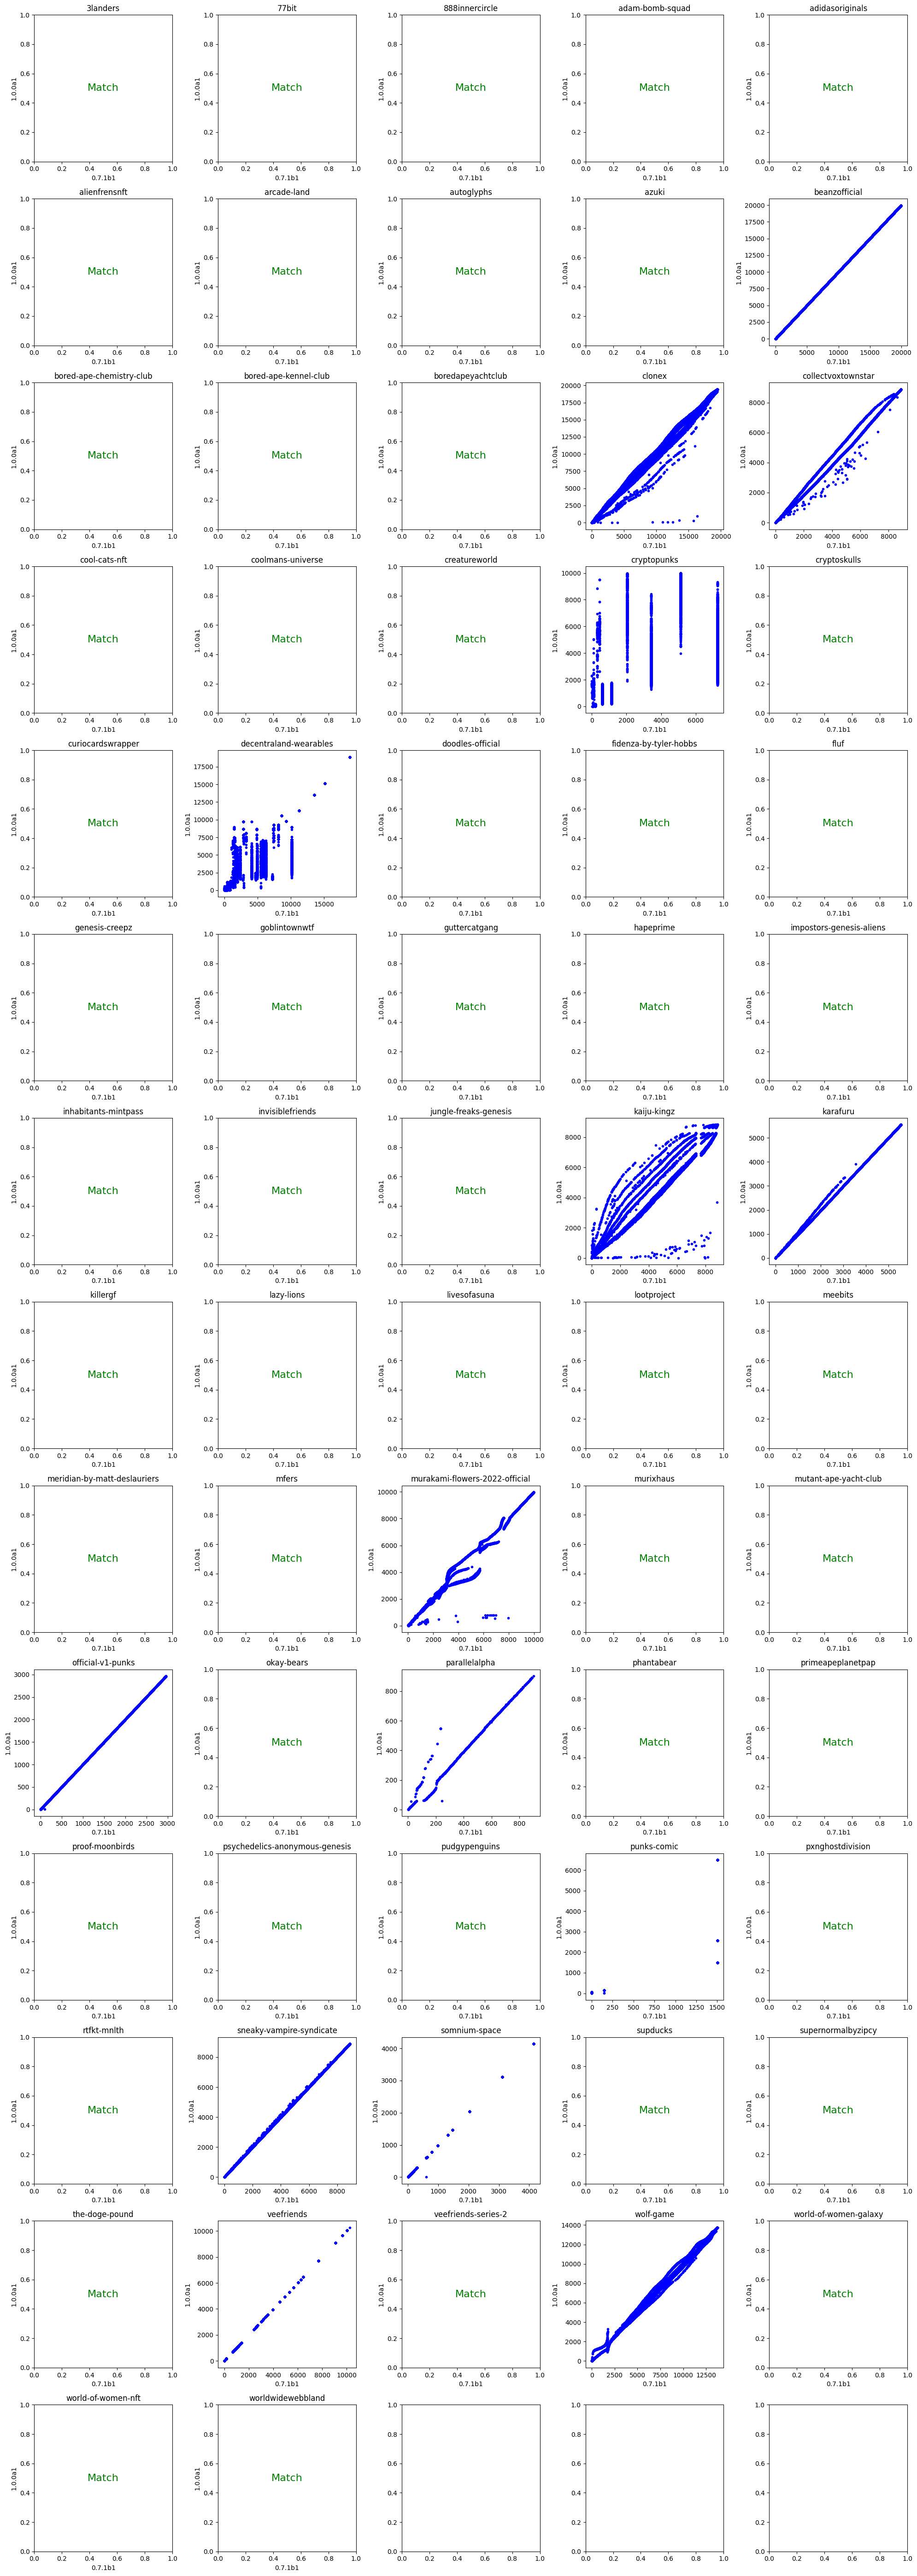

In [6]:
_100a1 = {p.stem: p for p in (DATA / "1.0.0a1").glob("*.json")}
_071b0 = {p.stem: p for p in (DATA / "0.7.1b0").glob("*.json")}
collections = sorted(set(_100a1).intersection(set(_071b0)))

plt.close("all")
ncols = 5
nrows = math.ceil(len(collections) / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 4))
axes = axes.flatten()

comps = {}
matches = defaultdict(list)
for i, c in enumerate(collections):
    old = pd.DataFrame(json.loads(_071b0[c].read_text()))
    new = pd.DataFrame(json.loads(_100a1[c].read_text()))

    joined = pd.merge(old, new, on="token_id", suffixes=("_0.7.1b0", "_1.0.0a1"))
    _matches = bool(np.prod(joined["rank_0.7.1b0"] == joined["rank_1.0.0a1"]))
    matches[_matches].append(c)
    comps[c] = joined
    axes[i].set_title(c)
    axes[i].set_xlabel("0.7.1b1", fontsize=10)
    axes[i].set_ylabel("1.0.0a1", fontsize=10)
    if not _matches:
        axes[i].plot(joined["rank_0.7.1b0"], joined["rank_1.0.0a1"], "b.")
    if _matches:
        axes[i].annotate(
            "Match",
            xy=(0.5, 0.5),
            xytext=(0.5, 0.5),
            xycoords="axes fraction",
            color="green",
            fontsize=16,
            ha="center",
            va="center",
        )
print(f"Match: {len(matches[True])}\tMisMatch: {len(matches[False])}")
fig.tight_layout()

fig.savefig(str(DATA / "Matches.png"))
plt.show()


In [7]:
matches[False]

['beanzofficial',
 'clonex',
 'collectvoxtownstar',
 'cryptopunks',
 'decentraland-wearables',
 'kaiju-kingz',
 'karafuru',
 'murakami-flowers-2022-official',
 'official-v1-punks',
 'parallelalpha',
 'punks-comic',
 'sneaky-vampire-syndicate',
 'somnium-space',
 'veefriends',
 'wolf-game']

In [2]:
from IPython.display import display

col_data = {}
for COLLECTION in ["beanzofficial"]:# tqdm(matches[False]):
    data = json.loads((DATA / f"metadata/{COLLECTION}.json").read_text())
    tc = TokenCollection("non-fungible", data)
    ranks = tc.rank_collection()
    _071b0_ranks = pd.DataFrame(
        json.loads((DATA / f"0.7.1b0/{COLLECTION}.json").read_text())
    )
    _071b0_counts = json.loads((DATA / f"0.7.1b0/counts/{COLLECTION}.json").read_text())
    _100a1_ranks = pd.DataFrame(ranks)
    token_stats = pd.DataFrame(tc.token_statistics)
    counted = token_stats.groupby(["token_id", "name"]).count()[["value"]].sort_values("value", ascending=False)
    counted = counted[counted["value"] > 1].groupby("token_id").count().rename({"value": "duplicated_trait_count"}, axis=1)
    combined = pd.merge(pd.merge(
        _071b0_ranks, _100a1_ranks, on="token_id", suffixes=("_0.7.1b0", "_1.0.0a1")
    )[
        [
            "token_id",
            "metric.unique_trait_count_0.7.1b0",
            "metric.unique_trait_count_1.0.0a1",
            "metric.information_entropy_0.7.1b0",
            "metric.information_entropy_1.0.0a1",
            "rank_0.7.1b0",
            "rank_1.0.0a1",
        ]
    ].sort_values("rank_0.7.1b0"), counted, on="token_id", how="left")
    combined["duplicated_trait_count"] = combined["duplicated_trait_count"].fillna(0).astype(int)
    combined["shift"] = combined["rank_0.7.1b0"] - combined["rank_1.0.0a1"]
    col_data[COLLECTION] = combined
    combined.to_csv(DATA / f"ranked/{COLLECTION}.csv", index=False)
for col, data in col_data.items():
    print(col)
    display(data.head(10))


beanzofficial


,token_id,metric.unique_trait_count_0.7.1b0,metric.unique_trait_count_1.0.0a1,metric.information_entropy_0.7.1b0,metric.information_entropy_1.0.0a1,rank_0.7.1b0,rank_1.0.0a1,duplicated_trait_count,shift
0,53,1,1,1.922965,1.922965,1,1,0,0
1,7117,1,1,1.867184,1.867184,2,3,0,-1
2,14002,1,1,1.479080,1.479080,3,4,0,-1
3,1257,1,1,1.353641,1.353641,4,5,0,-1
4,9466,1,1,1.210747,1.210747,5,6,0,-1
5,13321,0,0,2.371412,2.371412,6,7,0,-1
6,9617,0,0,2.257776,2.257776,7,8,0,-1
7,1455,0,0,2.246863,2.246863,8,9,0,-1
8,12086,0,0,2.208560,2.208560,9,10,0,-1
9,1193,0,0,2.184002,2.184002,10,11,0,-1


In [4]:
data[data["token_id"] == "13365"]

,token_id,metric.unique_trait_count_0.7.1b0,metric.unique_trait_count_1.0.0a1,metric.information_entropy_0.7.1b0,metric.information_entropy_1.0.0a1,rank_0.7.1b0,rank_1.0.0a1,duplicated_trait_count,shift
46,13365,0,1,1.904785,1.904785,47,2,0,45


In [11]:
combined["abs_shift"] = np.abs(combined["shift"])
combined.sort_values("abs_shift", ascending=False)

,token_id,metric.unique_trait_count_0.7.1b0,metric.unique_trait_count_1.0.0a1,metric.information_entropy_0.7.1b0,metric.information_entropy_1.0.0a1,rank_0.7.1b0,rank_1.0.0a1,duplicated_trait_count,shift,abs_shift
4857,3008,0,0,0.977077,0.972618,4858,5112,0,-254,254
4871,7912,0,0,0.976675,0.972285,4872,5125,0,-253,253
4883,2366,0,0,0.976531,0.972233,4884,5127,0,-243,243
4829,747,0,0,0.977688,0.973492,4830,5067,0,-237,237
4540,8584,0,0,0.985361,0.981089,4541,4775,0,-234,234
...,...,...,...,...,...,...,...,...,...,...
4958,6981,0,0,0.974851,0.976522,4959,4959,0,0,0
4951,5106,0,0,0.975088,0.976592,4952,4952,0,0,0
4936,2400,0,0,0.975369,0.976946,4937,4937,0,0,0
4905,6744,0,0,0.976109,0.977614,4906,4906,0,0,0


In [12]:
token_stats[token_stats["token_id"] == "3008"]

,token_id,name,value,display_type,token.supply,attribute.token_count,attribute.supply,metric.probability,metric.information
39045,3008,head,blue,string,1,2908,2908,0.327183,1.611832
39046,3008,eyes,bloodshot,string,1,628,628,0.070657,3.823022
39047,3008,background,orange,string,1,583,583,0.065594,3.930291
39048,3008,hair,openrarity.null_trait,string,1,106,106,0.011926,6.389723
39049,3008,hat,openrarity.null_trait,string,1,3058,3058,0.344059,1.539270
39050,3008,mouth,tongue,string,1,952,952,0.107111,3.222825
39051,3008,glasses,openrarity.null_trait,string,1,2207,2207,0.248312,2.009772
39052,3008,clothes,black tracksuit,string,1,314,314,0.035329,4.823022
39053,3008,beard,stubble,string,1,1175,1175,0.132201,2.919198
39054,3008,moon,moon,string,1,5571,5571,0.626800,0.673923


In [15]:
old_attr = pd.DataFrame(
    np.array(
        [
            [
                "accessory",
                "background",
                "beard",
                "body",
                "clothes",
                "eyes",
                "glasses",
                "hair",
                "hat",
                "head",
                "meta_trait:trait_count",
                "moon",
                "mouth",
                "unique",
            ],
            [
                2.611813106082868,
                15.245283018867925,
                7.564255319148936,
                3.0563961485557085,
                28.305732484076433,
                14.152866242038217,
                4.056595162026472,
                98.75555555555556,
                2.9217619986850756,
                3.0563961485557085,
                34.99212598425197,
                1.595404774726261,
                9.336134453781513,
                1.0018034265103697,
            ],
        ]
    ).T,
    columns=["name", "score"],
)


In [16]:
pd.merge(token_stats[token_stats["token_id"] == "3008"], old_attr, on="name")

,token_id,name,value,display_type,token.supply,attribute.token_count,attribute.supply,metric.probability,metric.information,score
0,3008,head,blue,string,1,2908,2908,0.327183,1.611832,3.0563961485557085
1,3008,eyes,bloodshot,string,1,628,628,0.070657,3.823022,14.152866242038217
2,3008,background,orange,string,1,583,583,0.065594,3.930291,15.245283018867925
3,3008,hair,openrarity.null_trait,string,1,106,106,0.011926,6.389723,98.75555555555556
4,3008,hat,openrarity.null_trait,string,1,3058,3058,0.344059,1.539270,2.9217619986850756
5,3008,mouth,tongue,string,1,952,952,0.107111,3.222825,9.336134453781513
6,3008,glasses,openrarity.null_trait,string,1,2207,2207,0.248312,2.009772,4.056595162026472
7,3008,clothes,black tracksuit,string,1,314,314,0.035329,4.823022,28.305732484076433
8,3008,beard,stubble,string,1,1175,1175,0.132201,2.919198,7.564255319148936
9,3008,moon,moon,string,1,5571,5571,0.626800,0.673923,1.595404774726261


In [19]:
data = json.loads((DATA / "0.7.1b0/counts/sneaky-vampire-syndicate.json").read_text())
data = [{"name": k, "value": value, "count": count} for k, counts in data.items() for value, count in counts.items()]
old_counts = pd.DataFrame(data)

In [37]:
df = pd.merge(pd.merge(token_stats[token_stats["token_id"] == "3008"], old_attr, on="name"), old_counts, on=["name", "value"], how="left")
df

,token_id,name,value,display_type,token.supply,attribute.token_count,attribute.supply,metric.probability,metric.information,score,count,probability,information
0,3008,head,blue,string,1,2908,2908,0.327183,1.611832,3.0563961485557085,2908.0,0.327183,1.611832
1,3008,eyes,bloodshot,string,1,628,628,0.070657,3.823022,14.152866242038217,628.0,0.070657,3.823022
2,3008,background,orange,string,1,583,583,0.065594,3.930291,15.245283018867925,583.0,0.065594,3.930291
3,3008,hair,openrarity.null_trait,string,1,106,106,0.011926,6.389723,98.75555555555556,NaN,NaN,NaN
4,3008,hat,openrarity.null_trait,string,1,3058,3058,0.344059,1.539270,2.9217619986850756,NaN,NaN,NaN
5,3008,mouth,tongue,string,1,952,952,0.107111,3.222825,9.336134453781513,952.0,0.107111,3.222825
6,3008,glasses,openrarity.null_trait,string,1,2207,2207,0.248312,2.009772,4.056595162026472,NaN,NaN,NaN
7,3008,clothes,black tracksuit,string,1,314,314,0.035329,4.823022,28.305732484076433,314.0,0.035329,4.823022
8,3008,beard,stubble,string,1,1175,1175,0.132201,2.919198,7.564255319148936,1175.0,0.132201,2.919198
9,3008,moon,moon,string,1,5571,5571,0.626800,0.673923,1.595404774726261,5571.0,0.626800,0.673923


In [30]:
tc.entropy

40.164315862993185

In [24]:
token_stats["token_id"].unique().shape[0]

8888

In [27]:
old_counts["probability"] = old_counts["count"] / 8888
old_counts["information"] = -np.log2(old_counts["probability"])

In [35]:
old_counts[old_counts["name"] == "meta_trait:trait_count"]

,name,value,count,probability,information
196,meta_trait:trait_count,10,3272,0.368137,1.441686
197,meta_trait:trait_count,11,3012,0.338884,1.561137
198,meta_trait:trait_count,9,1379,0.155153,2.688236
199,meta_trait:trait_count,12,941,0.105873,3.239592
200,meta_trait:trait_count,8,254,0.028578,5.128958
201,meta_trait:trait_count,7,14,0.001575,9.310288
202,meta_trait:trait_count,1,16,0.001800,9.117643


In [39]:
df["name"].unique()

array(['head', 'eyes', 'background', 'hair', 'hat', 'mouth', 'glasses',
       'clothes', 'beard', 'moon', 'body', 'accessory', 'unique'],
      dtype=object)

In [45]:
attr_df = pd.DataFrame(tc.attribute_statistics["string"])
attr_df[attr_df["name"] == "openrarity.trait_count"]

,name,value,attribute.token_count,attribute.supply,metric.probability,metric.information
12,openrarity.trait_count,10,3272,3272,0.368137,1.441686
31,openrarity.trait_count,11,3012,3012,0.338884,1.561137
48,openrarity.trait_count,9,1379,1379,0.155153,2.688236
103,openrarity.trait_count,12,941,941,0.105873,3.239592
156,openrarity.trait_count,8,254,254,0.028578,5.128958
169,openrarity.trait_count,7,14,14,0.001575,9.310288
195,openrarity.trait_count,1,16,16,0.001800,9.117643


In [46]:
token_stats[token_stats["token_id"] == "3008"]

,token_id,name,value,display_type,token.supply,attribute.token_count,attribute.supply,metric.probability,metric.information
39045,3008,head,blue,string,1,2908,2908,0.327183,1.611832
39046,3008,eyes,bloodshot,string,1,628,628,0.070657,3.823022
39047,3008,background,orange,string,1,583,583,0.065594,3.930291
39048,3008,hair,openrarity.null_trait,string,1,106,106,0.011926,6.389723
39049,3008,hat,openrarity.null_trait,string,1,3058,3058,0.344059,1.539270
39050,3008,mouth,tongue,string,1,952,952,0.107111,3.222825
39051,3008,glasses,openrarity.null_trait,string,1,2207,2207,0.248312,2.009772
39052,3008,clothes,black tracksuit,string,1,314,314,0.035329,4.823022
39053,3008,beard,stubble,string,1,1175,1175,0.132201,2.919198
39054,3008,moon,moon,string,1,5571,5571,0.626800,0.673923
